Анализ ПИФа "Сбербанк Америка" и его сравнение c benchmark portfolio 

In [74]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.data as web
from dbfpy import dbf

In [55]:
%matplotlib inline
plt.style.use('fivethirtyeight') # The most fanciest styles are 'ggplot' and 'fivethirtyeight'
# All available styles may be checked by
#print plt.style.available

Данные фонда в формате csv могут быть взяты из 
http://www.sberbank-am.ru/rus/Individuals/Mutual_Funds/Federal/index.wbp

In [71]:
csvfilename = 'Sberbank  America.csv'
usdratefilename = 'R01235.dbf'

In [131]:
def get_rate(date):
    try:
        return usdrates[date]
    except KeyError:
        return get_rate(date-datetime.timedelta(1))

Парсинг исторических значений курса доллара к рублю

In [111]:
usdrates = {}
db = dbf.Dbf(usdratefilename)
for rec in db:
    date = rec[0]
    rate = float(rec[2])
    usdrates[date]=rate

Парсинг исторических данных ПИФа:

In [142]:
dates = []
prices = []
with open(csvfilename, 'rb') as csvfile:
    datareader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row, r in zip(datareader, usdrates) :
        date = datetime.datetime.strptime(row[0], "%d-%m-%y").date()
        price = float(row[1].replace(',','.'))
        usdprice = price / get_rate(date)
        #print row[0]
        dates.append(date)
        prices.append(usdprice)
        #print ', '.join(row)
end_date = dates[0]
start_date = dates[-1]

In [135]:
spy = pd.DataFrame()
spy = web.DataReader('SPY', data_source='yahoo', start=start_date, end=end_date)['Adj Close']  

Отношение долларовых цен 

In [143]:
prices[-1] 

37.80802752727204

In [144]:
spy[0]

117.41586399999998

In [146]:
rate = prices[-1]/spy[0]
print rate

0.322001016211


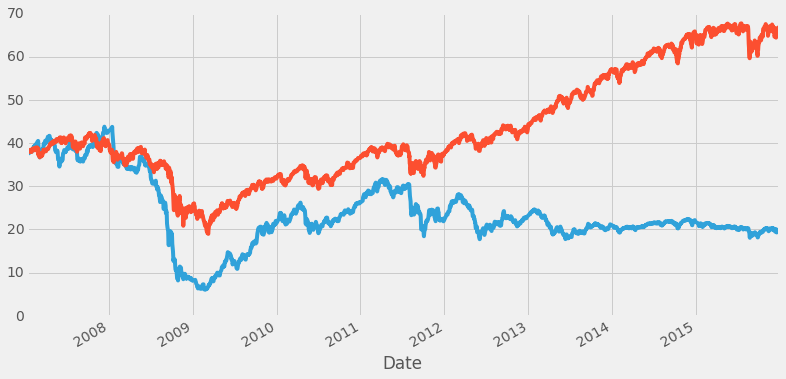

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Sberbank')
(spy * rate).plot()

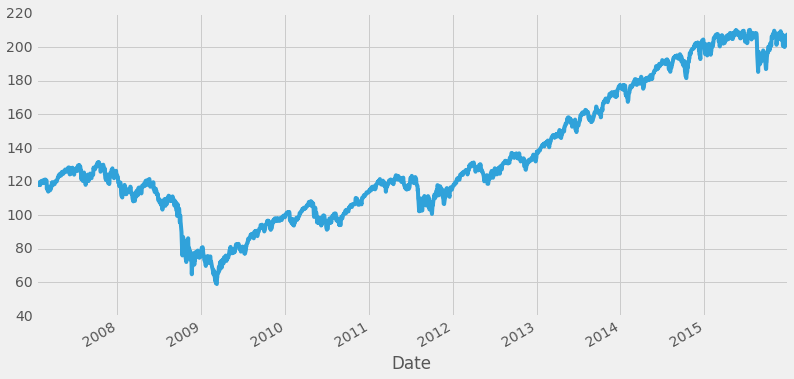

In [64]:
plt.figure(figsize=(12, 6))
spy.plot()